# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> There are many ways that such comparisons can be made. The most straight-foward and general way is by using some sort of statistical test that is conceived for comparing distributions (such as Kolmogorov-Smirnov's test). 

> One might also observe some key values of the distribution such as the min, max, mean, median and the quantiles. Significantly different values might indicate an incorrect distribution.

> Finally, especially in tabular data, one might also look into the conditional distributions. For an example where you have data that describes a person's salary and the city they live in, it might not suffice to perserve the distribution of salaries and of the cities. It might be interesting to also see if the distribution of the salary given a city might be preserved (i.e. given that someone lives in Paris it is expected for them to have higher salaries than someone in Lisbon). 

> If one desires to preserve some critical properties (especially conditional ones), it might be worth to also compare these conditional distributions with the usage of a test such as Kolmogorov-Smirnov's.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> Comparing the density of the distributions might prove a better holistic view of the generated dataset, but can certainly be more computationally expensive than simply comparing samples. This is particularly important since generative models are often already very computationally expensive by themselves, and benefit greatly from long training sessions.

> On the other hands, comparing sampled values is considerably more expensive. The negative part is that these samplings can not be very representative of the overall distribution. One way that this can happen is during heavy-tailed distributions. The presence of very few but very significant extreme values can easily be under or overestimated by sampling. This, in turn, might cause the creation of a generative model that is not representative of the actual distribution.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> The choice of N describes the degrees of freedom that this noise can have. Given a small enough N, especially when its considerably smaller from the input space for the generative network G, one might find in a situation that the output space is not fully uncovered by the input of the sampling. In other terms, sampling process is not surjective.

> This essentially means that the model is unable to generate the original distribution in its completude. As such, the quality of the generation will be compromised. Likewise, this also implies in an optimal situation that the discriminator will always be able to distinguish between real and sampled data on the cases of the input space which are not covered by $f_{\theta}(\epsilon)$. 

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> Using the JSD directly as training objective would essentially mean having an extremelly/ideally strong discriminator coupled with our generator. In practice, this implies that during the initial iterations of the Generator, this discriminator would be able to very confidently distinguish between the real and generated samples. 

> This means that instead of incrementally getting feedback in how to approximate the real distribution, the model is blocked near its initialization and does not receive correct feedback as all of its immediate surroundings are equally unable to satisfy the disciminator's high standards.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> Under this scenario, the generator is unable to receive feedback on the samples it was unable to generate. Assume a situation where the sampling process is not surjective. Under this assumption, there will be samples that are systematically always associated with the real dataset since the generator is unable to create them. As such, in these cases, a good enough discriminator can always find the correct solution.

> On this scenario, we then have the discriminator learning a fact about the sampling (that it is unable to generate all of the original real data space) but being unable to provide feedback to the generative function. On this example, the networks will not reach the minimax optimum state of 1/2 discrimination and the output will always be suboptimal. 

> On the other hand, if it was possible for this discriminator to provide some sort of feedback on these samples (and, likewise, that the architecture of the generator would allow the function to eventually become surjective), then the generator could progressively learn to cover the entire space of the real data, and the minimax optimal state could be reached.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [3]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

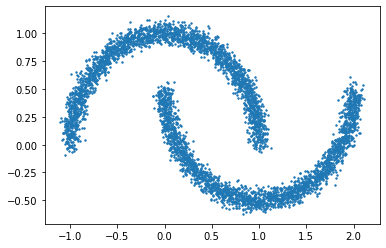

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        hidden_size = 10
        self.fc1 = nn.Linear(PRIOR_N, hidden_size)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.act5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.act6 = nn.ReLU()
        self.fc7 = nn.Linear(hidden_size, 2)
    

    def __call__(self, z):
        z = self.fc1(z)
        z = self.act1(z)
        z = self.fc2(z)
        z = self.act2(z)
        #z = self.fc3(z)
        #z = self.act3(z)
        #z = self.fc4(z)
        #z = self.act4(z)
        #z = self.fc5(z)
        #z = self.act5(z)
        #z = self.fc6(z)
        #z = self.act6(z)
        z = self.fc7(z)
        
        return z
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0).cuda()
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        hidden_size = 20

        self.fc1 = nn.Linear(PRIOR_N, hidden_size)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.act5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.act6 = nn.ReLU()
        self.fc7 = nn.Linear(hidden_size, 1)
        self.sig = nn.Sigmoid()
    
    def __call__(self, z):
        z = self.fc1(z)
        z = self.act1(z)
        z = self.fc2(z)
        z = self.act2(z)
        #z = self.fc3(z)
        #z = self.act3(z)
        #z = self.fc4(z)
        #z = self.act4(z)
        #z = self.fc5(z)
        #z = self.act5(z)
        #z = self.fc6(z)
        #z = self.act6(z)
        z = self.fc7(z)

        return self.sig(z)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.341e+00, generator: 7.258e-01
tensor([65.0041], device='cuda:0', grad_fn=<AddBackward0>)
tensor([62.0276], device='cuda:0', grad_fn=<AddBackward0>)


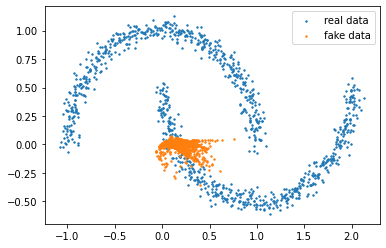

step 1000: discriminator: 1.116e+00, generator: 1.048e+00
tensor([77.8824], device='cuda:0', grad_fn=<AddBackward0>)
tensor([51.1753], device='cuda:0', grad_fn=<AddBackward0>)


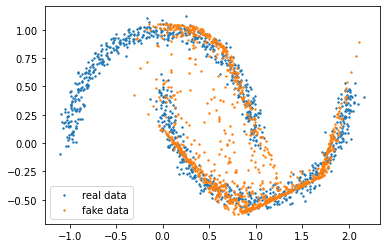

step 2000: discriminator: 1.315e+00, generator: 8.234e-01
tensor([68.2658], device='cuda:0', grad_fn=<AddBackward0>)
tensor([61.6375], device='cuda:0', grad_fn=<AddBackward0>)


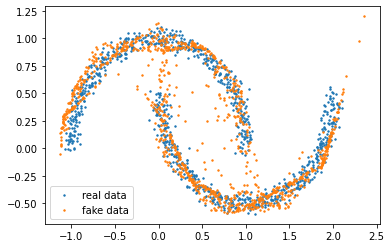

step 3000: discriminator: 1.311e+00, generator: 7.693e-01
tensor([68.0304], device='cuda:0', grad_fn=<AddBackward0>)
tensor([61.6851], device='cuda:0', grad_fn=<AddBackward0>)


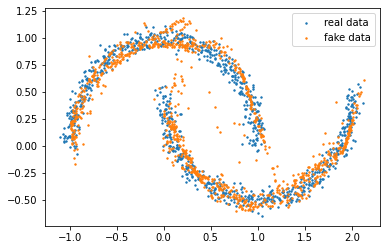

step 4000: discriminator: 1.362e+00, generator: 7.340e-01
tensor([67.8344], device='cuda:0', grad_fn=<AddBackward0>)
tensor([63.7914], device='cuda:0', grad_fn=<AddBackward0>)


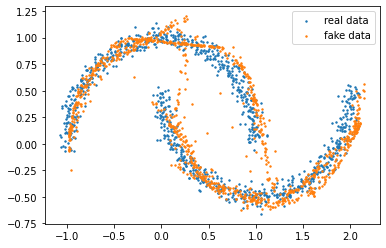

step 5000: discriminator: 1.341e+00, generator: 7.500e-01
tensor([64.9977], device='cuda:0', grad_fn=<AddBackward0>)
tensor([60.8368], device='cuda:0', grad_fn=<AddBackward0>)


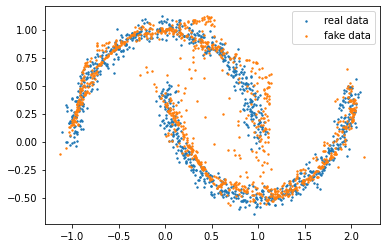

step 6000: discriminator: 1.314e+00, generator: 7.646e-01
tensor([65.6759], device='cuda:0', grad_fn=<AddBackward0>)
tensor([59.7258], device='cuda:0', grad_fn=<AddBackward0>)


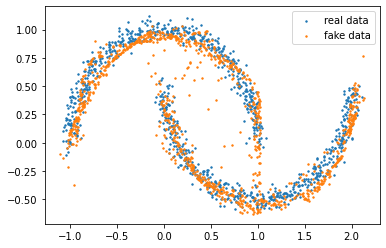

step 7000: discriminator: 1.339e+00, generator: 7.624e-01
tensor([65.0099], device='cuda:0', grad_fn=<AddBackward0>)
tensor([59.3755], device='cuda:0', grad_fn=<AddBackward0>)


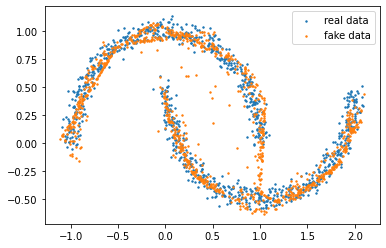

step 8000: discriminator: 1.367e+00, generator: 7.252e-01
tensor([67.1752], device='cuda:0', grad_fn=<AddBackward0>)
tensor([64.0383], device='cuda:0', grad_fn=<AddBackward0>)


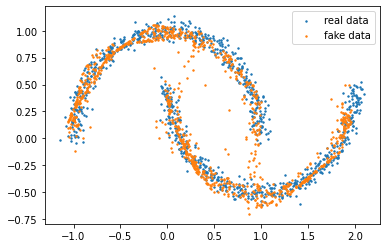

step 9000: discriminator: 1.358e+00, generator: 7.658e-01
tensor([64.9619], device='cuda:0', grad_fn=<AddBackward0>)
tensor([62.0294], device='cuda:0', grad_fn=<AddBackward0>)


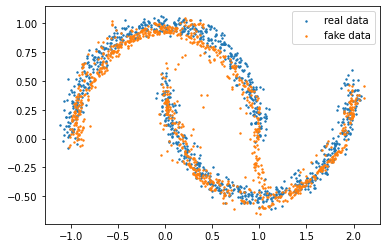

step 10000: discriminator: 1.360e+00, generator: 7.304e-01
tensor([66.5970], device='cuda:0', grad_fn=<AddBackward0>)
tensor([63.7186], device='cuda:0', grad_fn=<AddBackward0>)


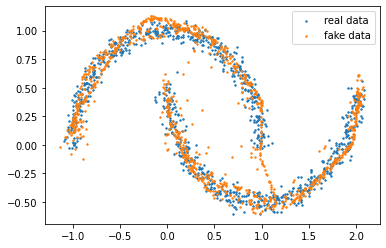

step 11000: discriminator: 1.349e+00, generator: 7.182e-01
tensor([66.2329], device='cuda:0', grad_fn=<AddBackward0>)
tensor([62.8767], device='cuda:0', grad_fn=<AddBackward0>)


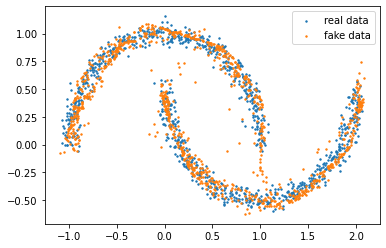

step 12000: discriminator: 1.370e+00, generator: 7.518e-01
tensor([65.7589], device='cuda:0', grad_fn=<AddBackward0>)
tensor([62.7912], device='cuda:0', grad_fn=<AddBackward0>)


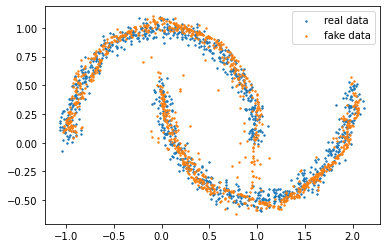

step 13000: discriminator: 1.379e+00, generator: 6.976e-01
tensor([65.7878], device='cuda:0', grad_fn=<AddBackward0>)
tensor([64.1533], device='cuda:0', grad_fn=<AddBackward0>)


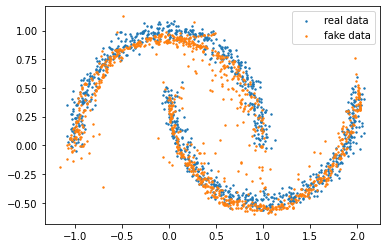

step 14000: discriminator: 1.357e+00, generator: 6.928e-01
tensor([65.9555], device='cuda:0', grad_fn=<AddBackward0>)
tensor([63.0371], device='cuda:0', grad_fn=<AddBackward0>)


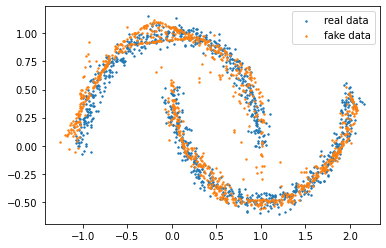

step 15000: discriminator: 1.358e+00, generator: 7.135e-01
tensor([65.7036], device='cuda:0', grad_fn=<AddBackward0>)
tensor([62.7452], device='cuda:0', grad_fn=<AddBackward0>)


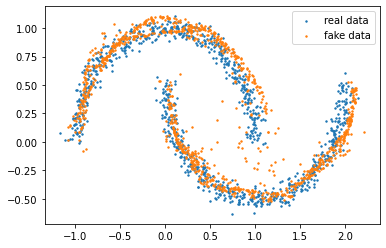

step 16000: discriminator: 1.375e+00, generator: 6.957e-01
tensor([67.4451], device='cuda:0', grad_fn=<AddBackward0>)
tensor([65.6596], device='cuda:0', grad_fn=<AddBackward0>)


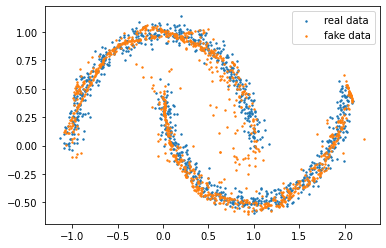

step 17000: discriminator: 1.363e+00, generator: 7.494e-01
tensor([65.6151], device='cuda:0', grad_fn=<AddBackward0>)
tensor([62.6780], device='cuda:0', grad_fn=<AddBackward0>)


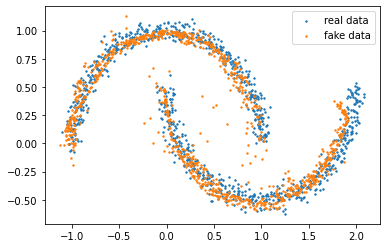

step 18000: discriminator: 1.386e+00, generator: 7.063e-01
tensor([65.6263], device='cuda:0', grad_fn=<AddBackward0>)
tensor([64.1594], device='cuda:0', grad_fn=<AddBackward0>)


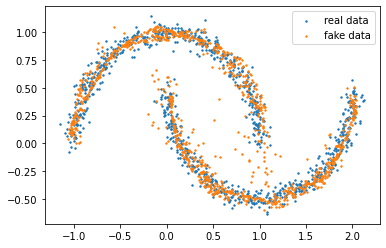

step 19000: discriminator: 1.390e+00, generator: 7.365e-01
tensor([64.3939], device='cuda:0', grad_fn=<AddBackward0>)
tensor([63.3190], device='cuda:0', grad_fn=<AddBackward0>)


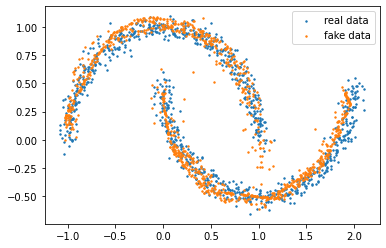

step 20000: discriminator: 1.359e+00, generator: 7.350e-01
tensor([65.5370], device='cuda:0', grad_fn=<AddBackward0>)
tensor([62.8177], device='cuda:0', grad_fn=<AddBackward0>)


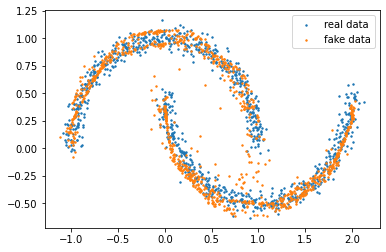

In [ ]:

# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 4
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator().cuda()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.003, betas=(0.5,0.99))
#optim_gen = torch.optim.Adam(generator.parameters(), lr=0.003, betas=(0.5,0.99))

#optim_gen = torch.optim.SGD(generator.parameters(), lr=1, momentum=0)

#criterion_gen = 

discriminator = Discriminator().cuda()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.003, betas=(0.5,0.99))
#optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.99))

#optim_disc = torch.optim.SGD(discriminator.parameters(), lr=1, momentum=0)

criterion = nn.BCELoss()

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        real_disc_prediction = discriminator(real_batch.cuda())
        #real_disc_prediction = torch.clamp(real_disc_prediction, min=0.0, max=1.0)
        real_loss = criterion(real_disc_prediction, torch.ones((BATCHLEN,1)).cuda())

        fake_disc_prediction = discriminator(fake_batch.cuda())
        #fake_disc_prediction = torch.clamp(fake_disc_prediction, min=0.0, max=1.0)
        fake_loss = criterion(fake_disc_prediction, torch.zeros((BATCHLEN,1)).cuda())

        disc_loss = real_loss + fake_loss
        #
        #disc_loss = 0
        disc_loss.backward()
        optim_disc.step()
    # train the generatorn
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    disc_pred = discriminator(fake_batch.cuda())
    #disc_pred = torch.clamp(disc_pred, min=0.0, max=1.0)
    gen_loss = criterion(disc_pred, torch.ones((BATCHLEN,1)).cuda())
    #gen_loss.backward()
    #
    #gen_loss = 0
    #gen_loss *= -1
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        print(sum(real_disc_prediction))
        print(sum(fake_disc_prediction))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        fake_batch_plot = fake_batch.cpu()
        plt.scatter(fake_batch_plot[:,0], fake_batch_plot[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> Under this loss, a perfect discriminator will show a 0 or close to 0 loss for a random input. This means that the result would be approximately $log(1) = 0$. This means that the gradient loss will be close to zero, meaning that the gradient will not get feedback on how to improve its synthetization and thus, the model will be stuck in a local minima with bad generation. 

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> Regarding model complexity, we've found that very simple models, are unable to replicate the curved shape of the real data. Thus, it is necessary for a model to go to a couple of passes on an activation function, ideally under a higher dimensional space, for these figures to be matched. A minimum depth to enable enough passes under a simple activation function (ReLU) was 3. 

> However, a tradeoff was also found in that too deep networks are both considerably slower and also present vanishing gradient. We found that especially on the discriminator, networks that pass 5-6 layers can often present a vanishing gradient, and thus be unable to progress much further than the initial state. It should be noted that this observation was under the alternative loss function $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ which reduces the vanishing gradient issues.

> Regarding width, we didn't notice any noticiable negative tradeoffs in adding more width. Therefore, on this example, we were more liberal with the width of our networks. 

> One thing to leave in consideration, however, was the fact that the quality of our GANs often had their bottleneck in the discriminator. Likewise, the issue of a too strong discriminator capping the learning was also not often found. As such, our best performing models had both more parameters in their discriminators, but also faster learning rates and larger train ratios. On this note, we found the ideal train ratio being 3-5x discriminator passes for each generator passes. A larger amount of discriminator passes increased the computational cost too much while providing little to no marginal benefit.

> In summary, our best performing models had 3-6 layers, each with 10-20 neurons of width and 3-5x train ratios. It should be noted that for best performance we set the discriminator to be a larger/more complex model than the generator (although ideally both models should stay on the aforementioned feature ranges).

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> We know that entropy is the average or the expectation of information and that cross-entropy measures the "proximity" of a true (p) and a predicted (q) distribution of random variables, so that if p=q then their entropy=cross-entropy. 
>
> The KL Divergence is a measure of dissimilarity between 2 distributions p and q and therefore measures how far away q is from p. 
>
> Entropy is defined as:
$$ H(p) = - \sum_i p_i \log(p_i)$$
>
> And Cross-Entropy is defined as:
$$ H(p,q) = -\sum_i p_i \log(q_i)$$
>
> And thus the KL-Divergence is defined as:
\begin{equation}
\begin{split}
D_{KL} (p ||q) &= H(p,q) - H(p) \\
              &= -\sum p(x) \log q(x) + \sum p(x) \log p(x) \\
              &= - \sum p(x) \log \frac{p(x)}{q(x)}
\end{split} 
\end{equation}

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](https://drive.google.com/uc?id=1eipNClrjZv5R8Bgmv7XqgpIry6fN2qj7)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> z is the latent space, in between the encoder and decoder and p(z) can be seen as the prior that simply represents how the latent variables are distributed without any conditioning. Often, p(z) is approximated with a learnt q(z) or simply N(0, 1). This could pose a problem if the approximation isn't accurate enough.
>
>Similarly, instead of decomposing x into deterministic z, we decompose it into its parameters, mu and sigma. These are then sampled to re-generate x'. We should indeed sample from these and not directly, in order to gain a better representation of the learned input. 

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**


> $D_{KL} = -\int{q(z) \log{p(z)} dz} + \int{q(z) \log{q(z)}dz}$
and \\
>
> assumption 1: $q(z) = N(\mu_1, \sigma_1)$ and $p(z)=N(\mu_2, \sigma_2)$ \\
>
> assumption 2: $p(z)$ is $N (0, Id )$
>
>First term: 
>
>\begin{equation}
\begin{split}
-\int{q(z) \log{p(z)} dx} &= \frac{1}{2} \log{(2\pi \sigma^2_2)} - \int q(z) (-\frac{(z-\mu_2)^2}{2\sigma^2_2})dz\\
                          &= \frac{1}{2} \log{(2\pi \sigma^2_2)} + \frac{\mathop{\mathbb{E}}[z^2] - 2\mathop{\mathbb{E}}[z]\mu_2+\mu^2_2}{2\sigma^2_2}\\
\end{split}
\end{equation}
>
>
>We know that the Variance $Var(z) = \mathop{\mathbb{E}}[x^2] - \mathop{\mathbb{E}}[x]^2 $ and thus $\mathop{\mathbb{E}}[x^2] = \sigma_1^2 + \mu_1^2$. This leads to:
>
>\begin{equation}
\begin{split}
                &= \frac{1}{2} \log{(2\pi \sigma^2_2)} + \frac{\sigma^2_1 + \mu^2_1 - 2\mu_1\mu_2 + \mu_2^2}{2\sigma^2_2}\\
                &= \frac{1}{2} \log{(2\pi \sigma^2_2)} +  \frac{\sigma_1^2 + (\mu_1-\mu_2)^2}{2\sigma^2_2}\\
\end{split}
\end{equation}
>
>Now as p(z) is a standard Gaussian, we can convert this further to:
>
>$$\frac{1}{2} \log(2\pi ) + \frac{1}{2}(\sigma_1^2 + \mu_1^2)$$
>
>Second term:
>\begin{equation}
\int q(z) \log q(z) dx = -\frac{1}{2} (1 + \log(2 \pi \sigma^2_1)
\end{equation}
>
>Combining the two terms: $D_{KL} = -\int{q(z) \log{p(z)} dz} + \int{q(z) \log{q(z)}dz}$
>
>$$\frac{1}{2} \log(2\pi ) + \frac{1}{2}(\sigma_1^2 + \mu_1^2) -\frac{1}{2} (1 + \log(2 \pi \sigma^2_1)$$
>
>$$= \frac{1}{2}(\sigma_1^2 + \mu_1^2) -\frac{1}{2}\log (\sigma_1^2) -\frac{1}{2}$$



We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> This questions aims at the second term of the lower bound loss, the reconstruction error:
$$\mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$
>
> Assuming that it also follows a Gaussian distribution with $N(\mu(z), Diag(\sigma^2(z))$ we can extend and express it in the following way:
>
> $$p(x|z) = (\frac{1}{(2\pi \sigma_\theta^2)^{\frac{1}{2}}}e^{(-\frac{1}{2}\frac{(x-\mu_\theta(z))^2}{\sigma_\theta^2(z)}})$$
>
> $$-\log p(x|z) = \frac{1}{2}\log (2\pi) + \frac{1}{2} \Sigma \log (\sigma_\theta^2(z)) + \frac{1}{2}\frac{(x-\mu_\theta(z))^2}{\sigma_\theta^2(z)}$$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [34]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 2.686e+00, rec: 5.633e-01


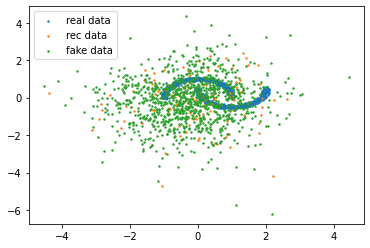

step 1000: KL: 6.649e-04, rec: 1.079e-01


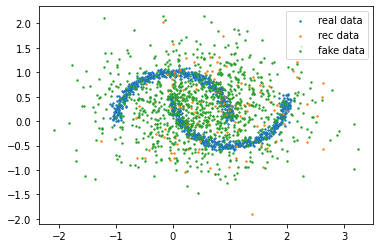

step 2000: KL: 3.401e-04, rec: 7.224e-02


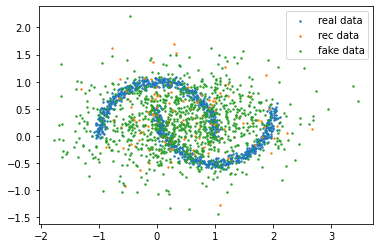

step 3000: KL: 8.710e-04, rec: 7.484e-02


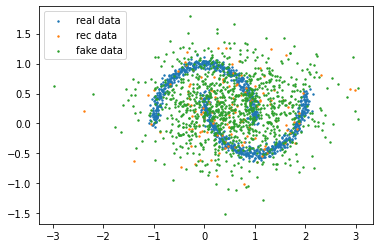

step 4000: KL: 5.019e-04, rec: 8.498e-02


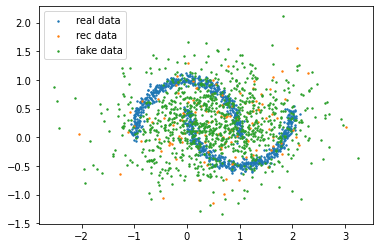

step 5000: KL: 4.618e-04, rec: 8.036e-02


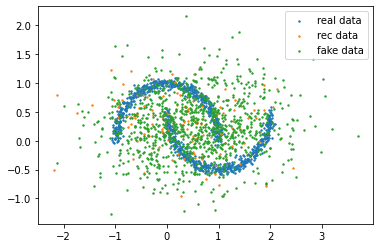

step 6000: KL: 4.723e-04, rec: 8.357e-02


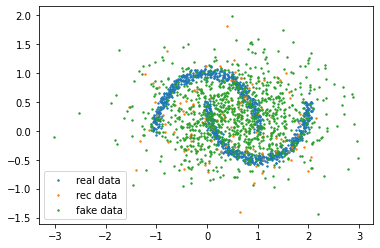

step 7000: KL: 6.746e-04, rec: 7.797e-02


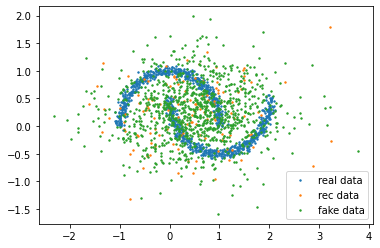

step 8000: KL: 7.293e-04, rec: 8.070e-02


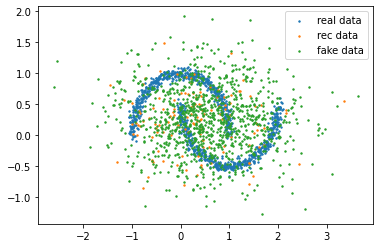

step 9000: KL: 8.593e-04, rec: 7.899e-02


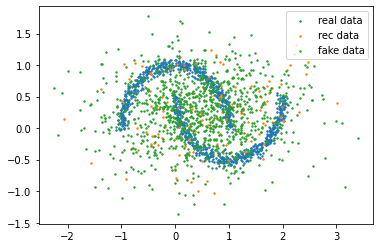

step 10000: KL: 2.836e-04, rec: 7.387e-02


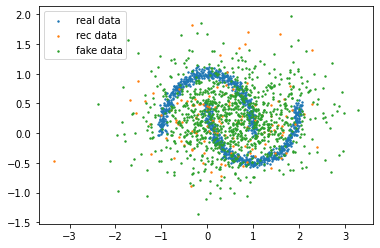

step 11000: KL: 5.243e-04, rec: 8.167e-02


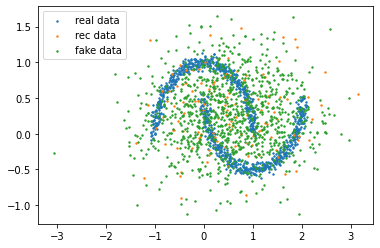

step 12000: KL: 3.207e-04, rec: 7.382e-02


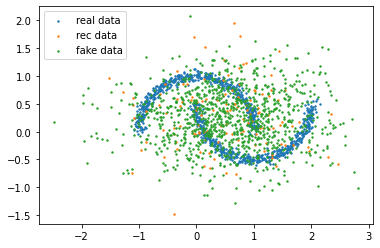

step 13000: KL: 8.396e-04, rec: 7.801e-02


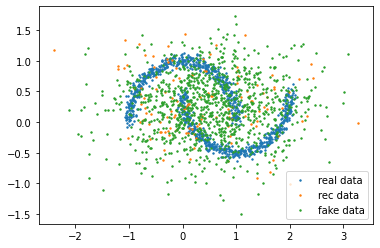

step 14000: KL: 1.223e-03, rec: 7.640e-02


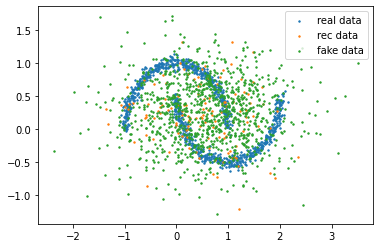

step 15000: KL: 6.319e-04, rec: 8.312e-02


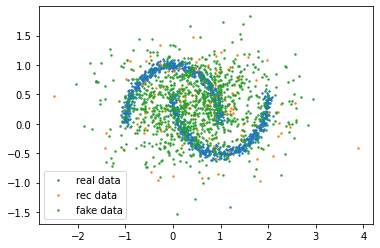

step 16000: KL: 2.510e-04, rec: 7.831e-02


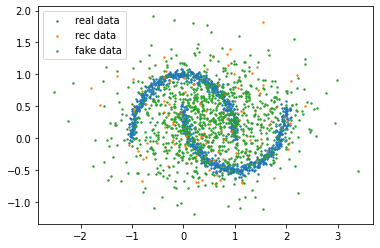

step 17000: KL: 8.575e-04, rec: 7.728e-02


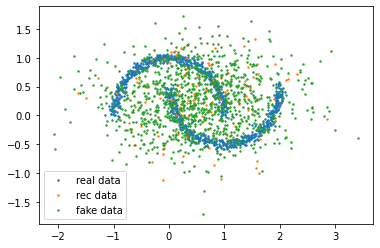

step 18000: KL: 8.204e-04, rec: 8.319e-02


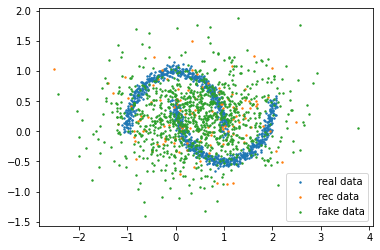

step 19000: KL: 6.381e-04, rec: 7.160e-02


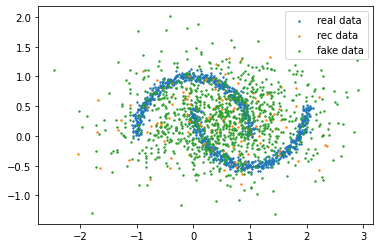

step 20000: KL: 5.094e-04, rec: 8.146e-02


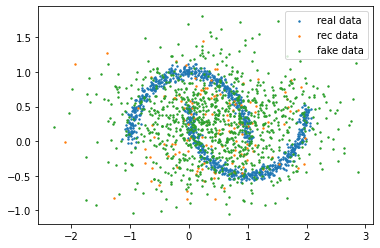

step 21000: KL: 1.223e-03, rec: 7.649e-02


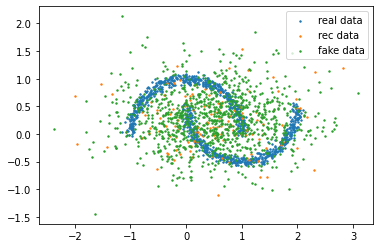

step 22000: KL: 4.609e-04, rec: 7.261e-02


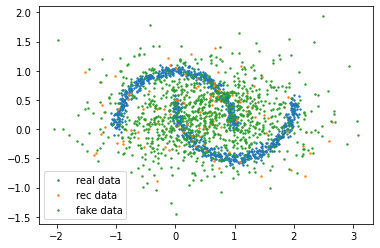

step 23000: KL: 6.512e-04, rec: 9.027e-02


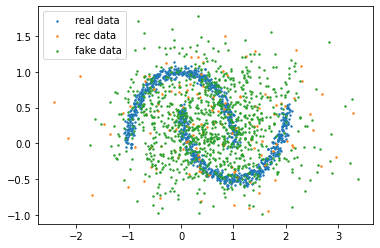

step 24000: KL: 6.181e-04, rec: 8.371e-02


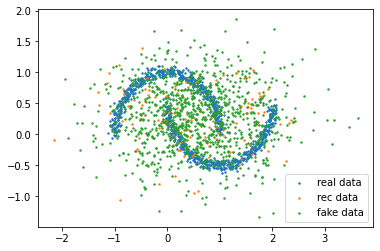

step 25000: KL: 5.772e-04, rec: 8.063e-02


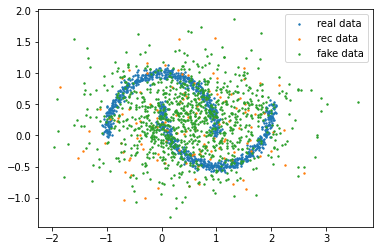

step 26000: KL: 2.266e-04, rec: 7.755e-02


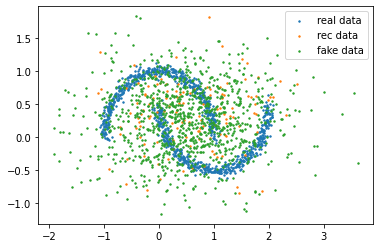

step 27000: KL: 5.087e-04, rec: 7.303e-02


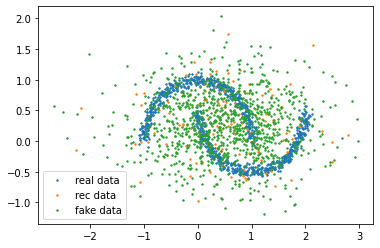

step 28000: KL: 4.785e-04, rec: 7.051e-02


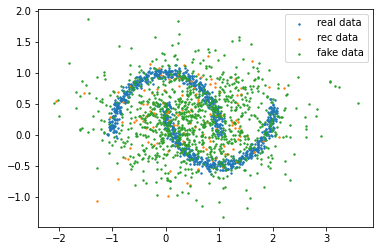

step 29000: KL: 9.718e-04, rec: 6.310e-02


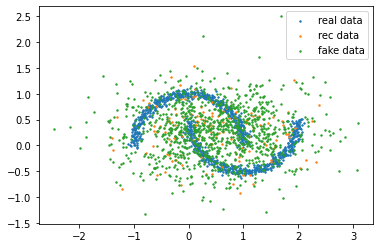

step 30000: KL: 7.049e-04, rec: 7.966e-02


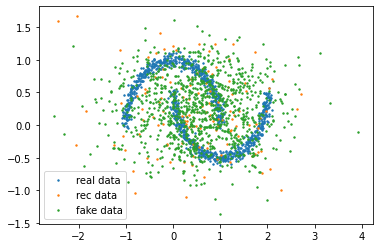

step 31000: KL: 6.768e-04, rec: 7.073e-02


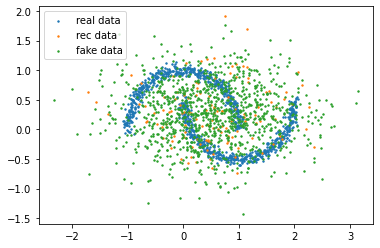

step 32000: KL: 7.445e-04, rec: 8.047e-02


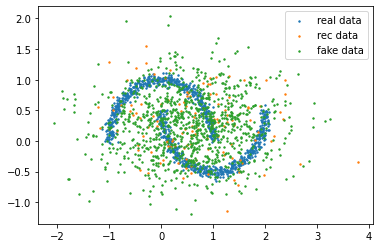

step 33000: KL: 6.208e-04, rec: 7.271e-02


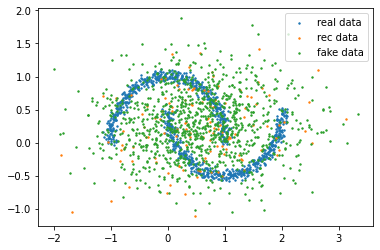

step 34000: KL: 3.624e-04, rec: 7.923e-02


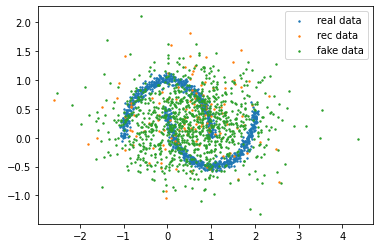

step 35000: KL: 4.504e-04, rec: 7.093e-02


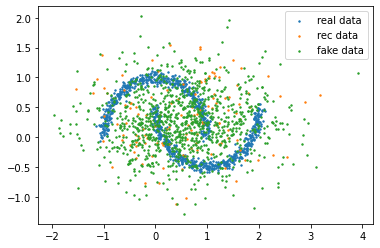

step 36000: KL: 8.224e-04, rec: 7.969e-02


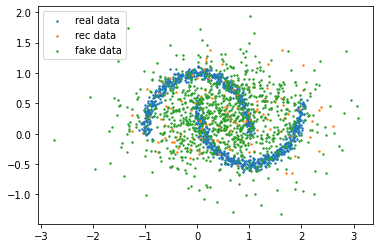

step 37000: KL: 5.449e-04, rec: 7.073e-02


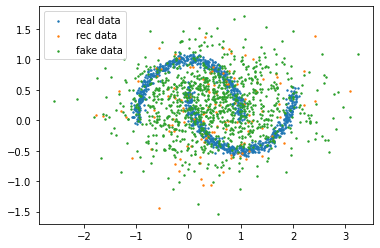

step 38000: KL: 4.492e-04, rec: 8.215e-02


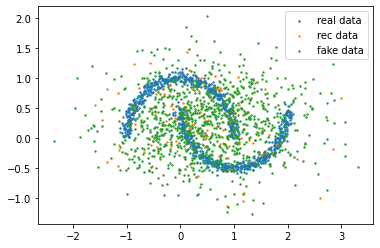

step 39000: KL: 5.492e-04, rec: 7.647e-02


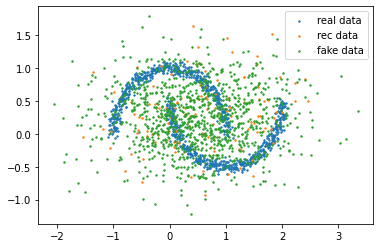

step 40000: KL: 6.690e-04, rec: 7.710e-02


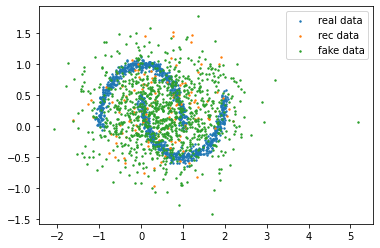

In [24]:
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = torch.mean(-0.5 * torch.sum(1 + enc_logvar - enc_mu ** 2 - enc_logvar.exp(), dim = 1), dim = 0)
    #loss_kl = -0.5 * torch.sum(1 + enc_logvar - enc_mu ** 2 - enc_logvar.exp(), dim = 1)
    #print(loss_kl)
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    '''
    std = torch.exp(enc_logvar / 2)
    q = torch.distributions.Normal(enc_mu, std)
    z = q.rsample()
    '''
    z = enc_mu + torch.normal(torch.zeros(BATCHLEN, LATENT_N), 1.) * torch.exp(enc_logvar / 2)
    #print(z)
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * torch.mean(dec_logvar + (x - dec_mu).pow(2) / torch.exp(dec_logvar))
    #print(loss_rec)
    
    (loss_kl + loss_rec).backward()
    #sum(loss_kl,loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

step 0: KL: 3.136e+00, rec: 7.506e-01


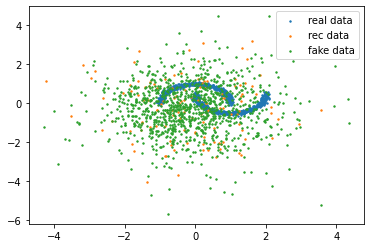

step 1000: KL: 2.816e-04, rec: 3.377e-01


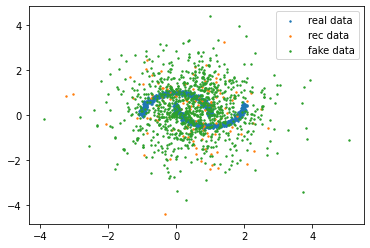

step 2000: KL: 1.142e-04, rec: 3.344e-01


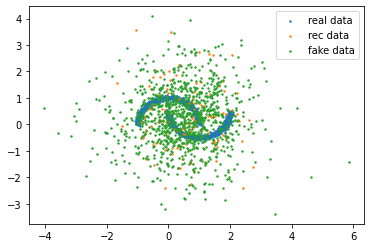

step 3000: KL: 1.296e-04, rec: 3.291e-01


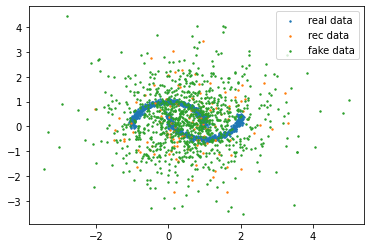

step 4000: KL: 1.027e-04, rec: 3.386e-01


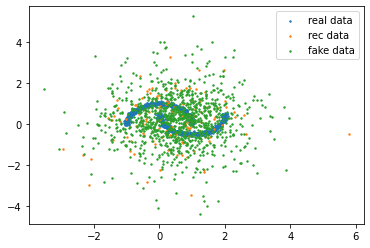

step 5000: KL: 7.149e-05, rec: 3.251e-01


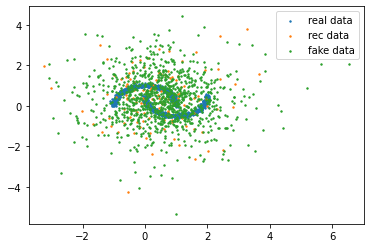

step 6000: KL: 1.151e-04, rec: 3.159e-01


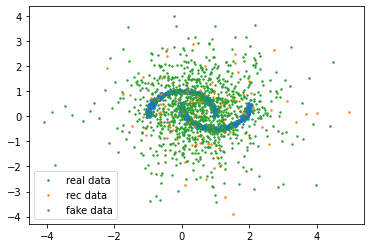

step 7000: KL: 8.579e-05, rec: 3.393e-01


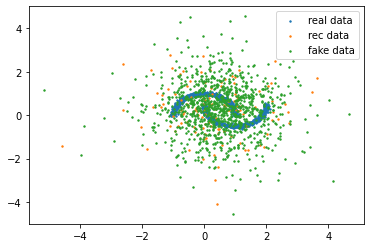

step 8000: KL: 1.411e-04, rec: 3.069e-01


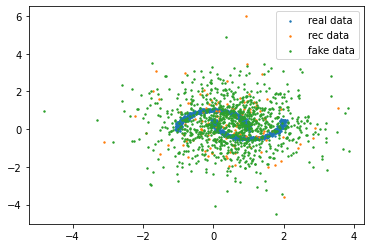

step 9000: KL: 1.423e-04, rec: 3.304e-01


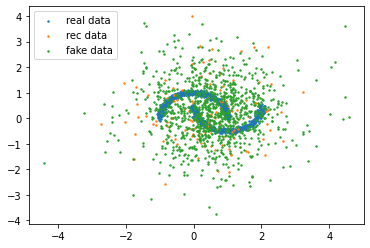

step 10000: KL: 3.394e-05, rec: 3.261e-01


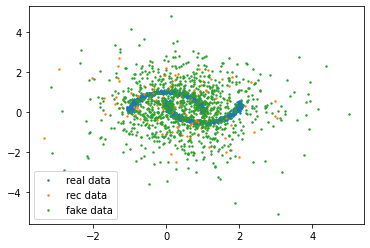

step 11000: KL: 8.618e-05, rec: 3.320e-01


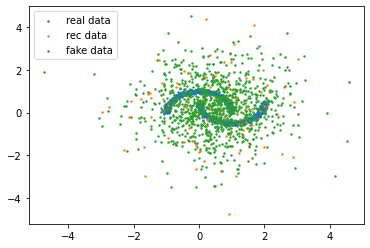

step 12000: KL: 1.797e-04, rec: 3.080e-01


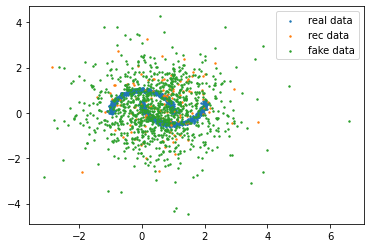

step 13000: KL: 1.165e-04, rec: 3.293e-01


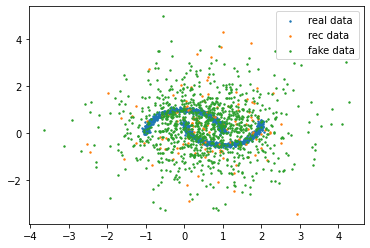

step 14000: KL: 6.907e-05, rec: 3.091e-01


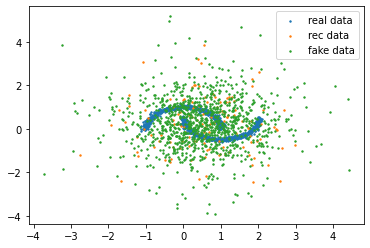

step 15000: KL: 1.029e-04, rec: 3.149e-01


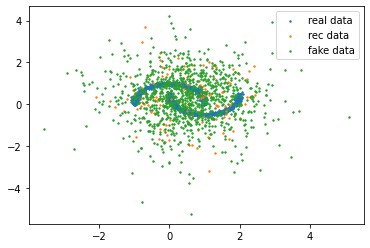

step 16000: KL: 4.461e-05, rec: 3.102e-01


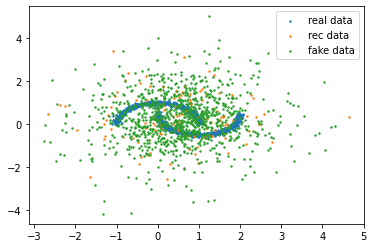

step 17000: KL: 9.241e-05, rec: 3.270e-01


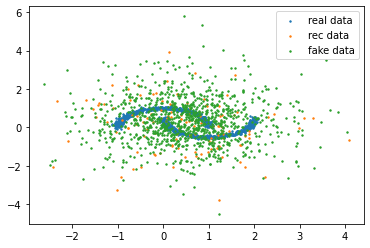

step 18000: KL: 8.646e-05, rec: 3.172e-01


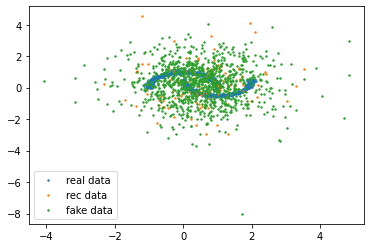

step 19000: KL: 8.352e-05, rec: 2.883e-01


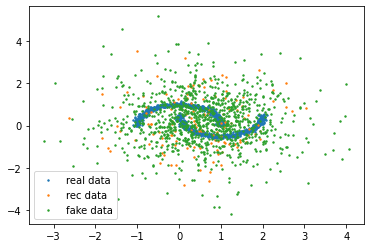

step 20000: KL: 1.389e-04, rec: 3.244e-01


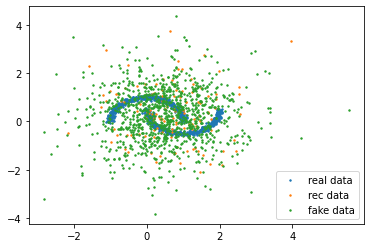

step 21000: KL: 9.036e-05, rec: 3.164e-01


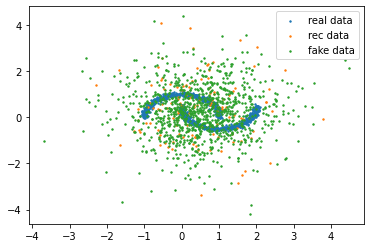

step 22000: KL: 1.015e-04, rec: 3.258e-01


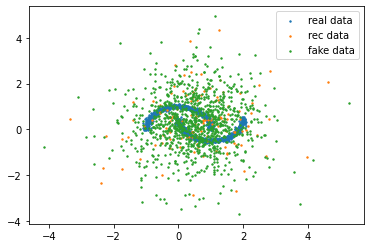

step 23000: KL: 5.366e-05, rec: 3.388e-01


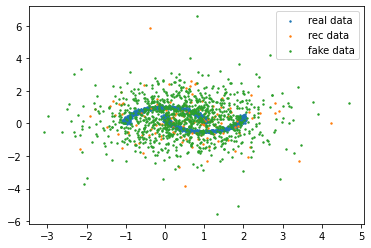

step 24000: KL: 9.358e-05, rec: 3.140e-01


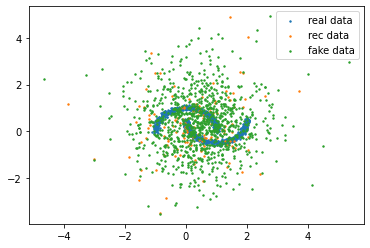

step 25000: KL: 3.911e-05, rec: 3.140e-01


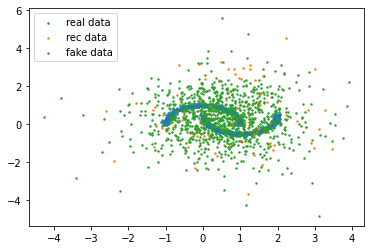

step 26000: KL: 2.341e-04, rec: 3.392e-01


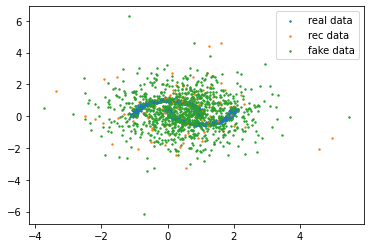

step 27000: KL: 3.878e-05, rec: 3.269e-01


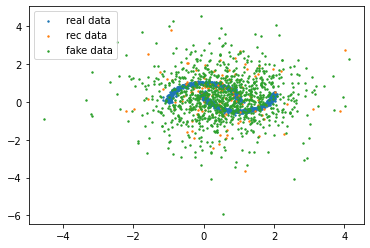

step 28000: KL: 1.683e-04, rec: 3.080e-01


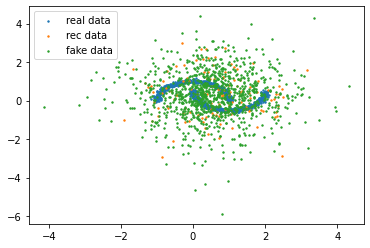

step 29000: KL: 1.058e-04, rec: 3.210e-01


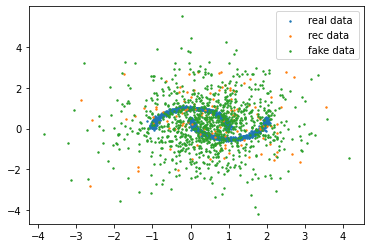

step 30000: KL: 1.324e-04, rec: 3.215e-01


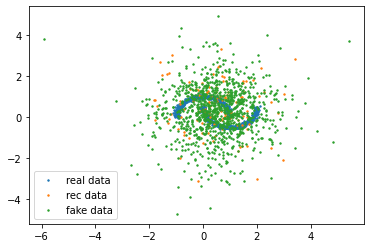

step 31000: KL: 5.336e-05, rec: 3.122e-01


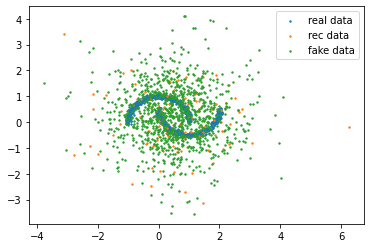

step 32000: KL: 9.395e-05, rec: 3.313e-01


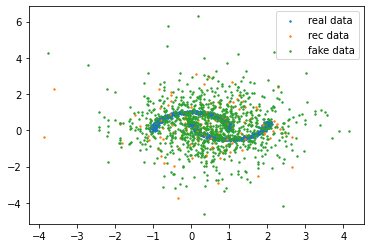

step 33000: KL: 6.404e-05, rec: 3.152e-01


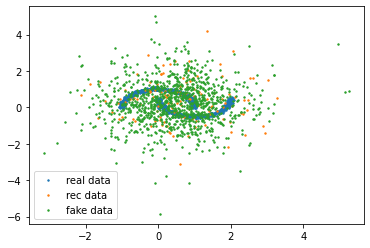

step 34000: KL: 1.548e-04, rec: 3.195e-01


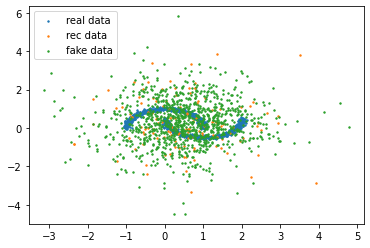

step 35000: KL: 8.084e-05, rec: 3.182e-01


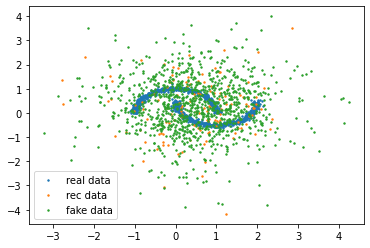

step 36000: KL: 5.763e-05, rec: 3.251e-01


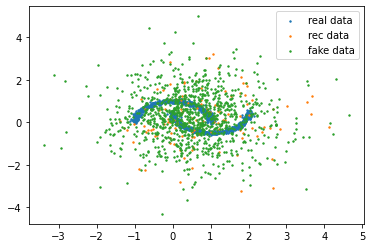

step 37000: KL: 8.925e-05, rec: 3.020e-01


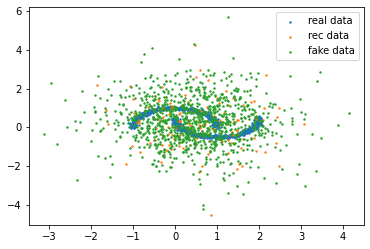

step 38000: KL: 1.226e-04, rec: 3.093e-01


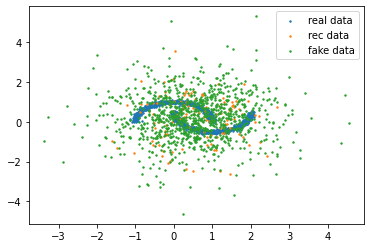

step 39000: KL: 2.863e-05, rec: 3.259e-01


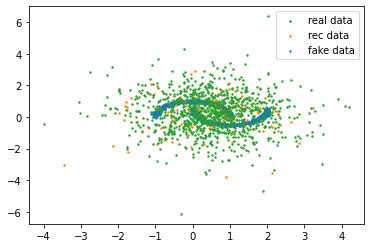

step 40000: KL: 1.225e-04, rec: 3.307e-01


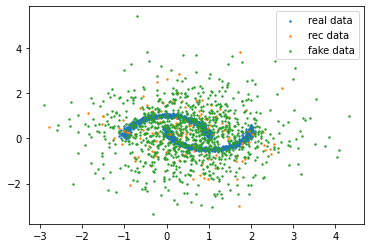

In [38]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))


#-----------------------------------------------------------------------------------------------------



# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = torch.mean(-0.5 * torch.sum(1 + enc_logvar - enc_mu ** 2 - enc_logvar.exp(), dim = 1), dim = 0)
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    z = enc_mu + torch.normal(torch.zeros(BATCHLEN, LATENT_N), 1.0) * torch.exp(enc_logvar / 2)
    
    dec_mu, dec_logvar = decoder(z)
    # HARDCODING DONE HERE
    dec_logvar = torch.autograd.Variable(dec_logvar, requires_grad=False)
    dec_logvar * 0.00001 # returns Variable
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * torch.mean(dec_logvar + (x - dec_mu).pow(2) / torch.exp(dec_logvar))
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

> Even though the non-hardcoded run of the code didn't seem to learn the datapoints very precisely, this one does it even less so. They are more spread out along both axes and generally present a less accurate version of fake data. 

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> The power of encoder and decoder of VAEs can have a significant effect on the training in that they define the dimensionality of the latent space output of the encoder network. If the encoder is powerful enough to put any N initial training data onto the real axis (each data point being encoded as a real value) and the decoder is powerful enough to decode them without any reconstruction loss, then the high degree of freedom of the autoencoder that makes possible to encode and decode with no information loss (despite the low dimensionality of the latent space) leads to a severe overfitting implying that some points of the latent space will give meaningless content once decoded.
>
> This can be made more understandable by assuming the input x is encoded down to N one-dimensional integers, so basically points on a line. The decoder could then reverse-transform them with no loss during the process. As these models are also used to induce transformability one important part is getting lost in such a process: the latent space becomes less interpretable and lacks regularity. Any unknown point is hard to reconstruct into a previously unseen shape in the reconstructed output.


### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> $$
z_{i−1} \sim p_{i−1}(z_{i−1})
$$
\
$$
z_i =f_i(z_{i−1}) \ \rightarrow \ z_{i−1} = f_{i}^{−1} (z_i)
$$
\
$$
p_i(z_i) = p_{i−1} (f_{i}^{−1}(z_i)) \mid det \frac{df_{i}^{−1}}{dz_i} \mid
$$
Then let’s convert the equation to be a function of $z_i$ so that we can do inference with the base distribution.
$$
p_i(z_i)=p_{i−1}(f^{−1}{i}(z_i)) \mid det \frac{df{i}^{−1}}{dz_i} \mid
$$
that according to the inverse func theorem becomes:
$$
p_i(z_i)=p_{i−1}(z_{i-1}) \mid det (\frac{df_{i}}{dz_i})^{-1} \mid
$$
given that the Jacobian in invertible becomes:
$$
p_i(z_i)=p_{i−1}(z_{i-1}) \mid det \frac{df_{i}}{dz_i} \mid ^{-1}
$$
$$
log(p_i(z_i))=log(p_{i−1}(z_{i-1})) - log (\mid det \frac{df_{i}}{dz_i} \mid)
$$

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> We can start from the indentity presented above:
>$$\log(p_X(x))=\log(p_Z(z))+\log \det J_f$$
>Then we can recall the definition for the KL divergence for 2 continuous variables:
$$D_{KL}(p||q) = \int p(x_i)\cdot log\frac{p(x_i)}{q(x_i)}
​​$$
>We can then consider that $x = f^{-1}(z)$ and can be re-written as such and inserting the identity inside the KL divergence we get:
$$
D_{KL}(p_x||p_z) = \int p(f^{-1}(z)) \cdot log\frac{p_z(z) \cdot \det J_f}{p_z(z)}
$$

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> \begin{cases} y_{1:d}=x_{1:d} \\ 
y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d}) 
\end{cases}
>
>If inverted becomes:
>
>\begin{cases} x_{1:d}=y_{1:d} \\ 
x_{d+1:D}=(y_{d+1:D} - t(y_{1:d})) \odot \exp(-s(y_{1:d})) 
\end{cases}

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> Given that the Jacobian is 
$$ J = 
\begin{bmatrix}
I_t & 0\\
\frac{∂y_{d+1:D}}{∂x_{1:d}} & diag(exp(s(x_{1:d})))
\end{bmatrix}
$$  \
>
>so it's a lower triangular matrix and the determinant is the product of the term of the Jacobian:
>
>$$
det(J)=∏_{j} exp(s(x_{1:d}))_j=exp(∑_{j} s(x_{1:d})_j)
$$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [1]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super(CouplingLayer, self).__init__()
        ### define here variables to use in f and s ###
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.mask = nn.Parameter(mask, requires_grad = False)

        self.s_net  = lambda: nn.Sequential(nn.Linear(input_size, hidden_size), nn.LeakyReLU(), nn.Linear(hidden_size, hidden_size), nn.LeakyReLU(), nn.Linear(hidden_size, output_size), nn.Tanh())
        self.t_net = lambda: nn.Sequential(nn.Linear(input_size, hidden_size), nn.LeakyReLU(), nn.Linear(hidden_size, hidden_size), nn.LeakyReLU(), nn.Linear(hidden_size, output_size))
        self.s = self.s_net()
        self.t = self.t_net()

    
    def sfun(self, x_m):
        ## compute scaling factor using unchanged part of x with a neural network
        x_m = self.s(x_m)*(1 - self.mask)        
        return x_m
        
    def tfun(self, x_m):
        ## compute translation using unchanged part of x with a neural network        
        x_m = self.t(x_m) * (1-self.mask)       
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_ = self.mask*y
        s_out = self.sfun(y_) # multiplicative block
        t_out = self.tfun(y_)
        y = (1 - self.mask) * (y - t_out) * torch.exp(-s_out) + y_
        return y

In [2]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1- mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [4]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [7]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [8]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.019163
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.011553
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.009216
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.007325
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.006409
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.005583
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.005058
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.005418
====> Epoch: 1 Average train loss: 0.0078


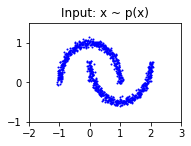

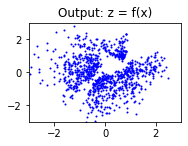

====> Test loss: 0.0052


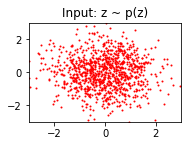

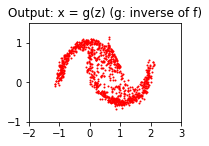

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.004275
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.005225
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.004673
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.005034
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.004811
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.005284
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.004694
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.004507
====> Epoch: 2 Average train loss: 0.0049


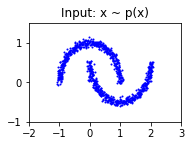

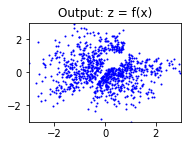

====> Test loss: 0.0045


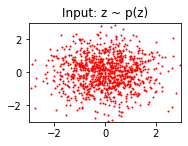

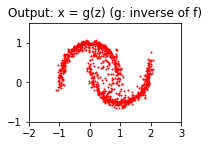

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.005447
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.004638
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.003736
Train Epoch: 3 [19200/50000 (38%)]	Loss: 0.003264
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.003959
Train Epoch: 3 [32000/50000 (64%)]	Loss: 0.003200
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.003833
Train Epoch: 3 [44800/50000 (90%)]	Loss: 0.003448
====> Epoch: 3 Average train loss: 0.0041


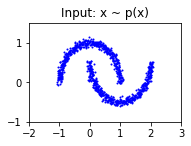

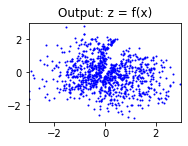

====> Test loss: 0.0037


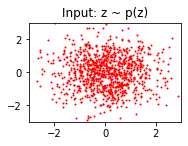

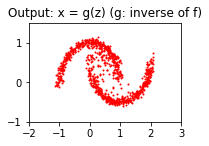

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.003487
Train Epoch: 4 [6400/50000 (13%)]	Loss: 0.003141
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.003177
Train Epoch: 4 [19200/50000 (38%)]	Loss: 0.002658
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.003736
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.005463
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.003349
Train Epoch: 4 [44800/50000 (90%)]	Loss: 0.002505
====> Epoch: 4 Average train loss: 0.0036


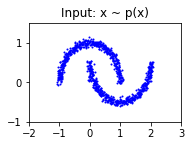

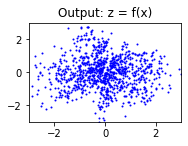

====> Test loss: 0.0036


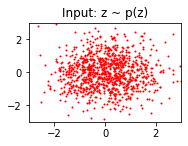

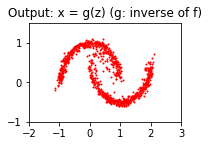

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.003781
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.002958
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.003761
Train Epoch: 5 [19200/50000 (38%)]	Loss: 0.002469
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.002782
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.003838
Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.004837
Train Epoch: 5 [44800/50000 (90%)]	Loss: 0.003325
====> Epoch: 5 Average train loss: 0.0032


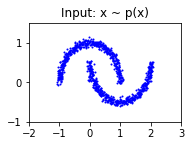

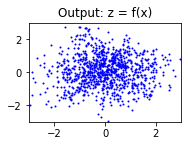

====> Test loss: 0.0031


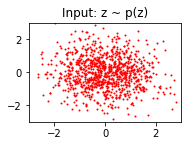

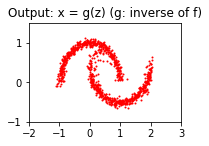

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.002684
Train Epoch: 6 [6400/50000 (13%)]	Loss: 0.003402
Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.002179
Train Epoch: 6 [19200/50000 (38%)]	Loss: 0.002917
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.002538
Train Epoch: 6 [32000/50000 (64%)]	Loss: 0.002436
Train Epoch: 6 [38400/50000 (77%)]	Loss: 0.003907
Train Epoch: 6 [44800/50000 (90%)]	Loss: 0.002025
====> Epoch: 6 Average train loss: 0.0031


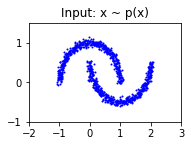

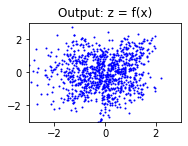

====> Test loss: 0.0035


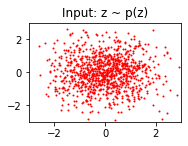

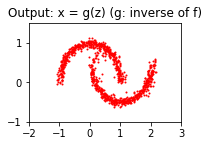

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.003761
Train Epoch: 7 [6400/50000 (13%)]	Loss: 0.002524
Train Epoch: 7 [12800/50000 (26%)]	Loss: 0.002469
Train Epoch: 7 [19200/50000 (38%)]	Loss: 0.003432
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.002750
Train Epoch: 7 [32000/50000 (64%)]	Loss: 0.002488
Train Epoch: 7 [38400/50000 (77%)]	Loss: 0.002812
Train Epoch: 7 [44800/50000 (90%)]	Loss: 0.002830
====> Epoch: 7 Average train loss: 0.0030


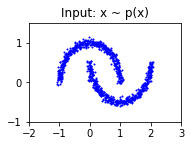

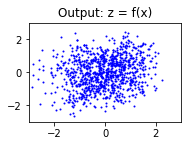

====> Test loss: 0.0030


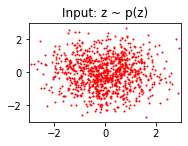

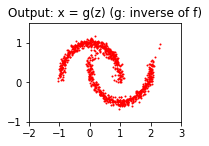

Train Epoch: 8 [0/50000 (0%)]	Loss: 0.002954
Train Epoch: 8 [6400/50000 (13%)]	Loss: 0.002598
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.003433
Train Epoch: 8 [19200/50000 (38%)]	Loss: 0.002941
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.003460
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.002886
Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.003890
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.003463
====> Epoch: 8 Average train loss: 0.0029


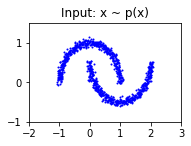

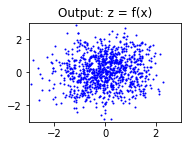

====> Test loss: 0.0029


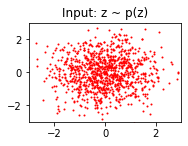

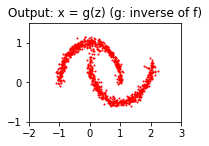

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.002762
Train Epoch: 9 [6400/50000 (13%)]	Loss: 0.002876
Train Epoch: 9 [12800/50000 (26%)]	Loss: 0.001710
Train Epoch: 9 [19200/50000 (38%)]	Loss: 0.003505
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.002791
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.003325
Train Epoch: 9 [38400/50000 (77%)]	Loss: 0.002972
Train Epoch: 9 [44800/50000 (90%)]	Loss: 0.002439
====> Epoch: 9 Average train loss: 0.0029


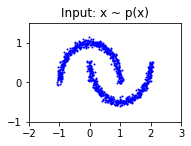

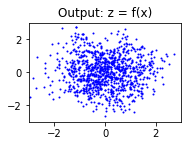

====> Test loss: 0.0029


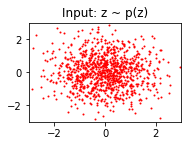

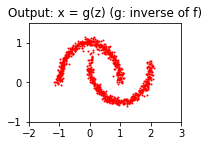

Train Epoch: 10 [0/50000 (0%)]	Loss: 0.002685
Train Epoch: 10 [6400/50000 (13%)]	Loss: 0.003729
Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.002264
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.002365
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.003221
Train Epoch: 10 [32000/50000 (64%)]	Loss: 0.002624
Train Epoch: 10 [38400/50000 (77%)]	Loss: 0.002686
Train Epoch: 10 [44800/50000 (90%)]	Loss: 0.004029
====> Epoch: 10 Average train loss: 0.0029


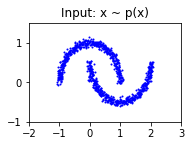

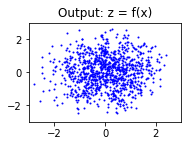

====> Test loss: 0.0028


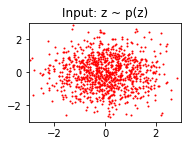

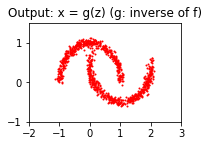

'115.13s'

<Figure size 432x288 with 0 Axes>

In [9]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> Real NVP fails by attributing
probability mass over spaces where the data distribution has low density. This is consistent
with the mode covering behavior of maximum likelihood. However, the particular inductive
bias of Real NVP is to prefer modeling the data as one connected manifold. This results
in the unwanted probability mass being distributed along the space between clusters.
>
> source: https://arxiv.org/pdf/1903.07714.pdf

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> GAN Advantages: Flexible approach ensures that it is valuable for a huge variety of input data (images, values, etc) with minimal adjustments beyond the models used for this type of data. For this reason as well, it is relatively simple to provide variations on GANs, since the overall approach is rather straight forward thus the model can easily be tailored for a specific use-case (see CTGANs for Conditionals or DPGANs for Privacy). 
>
>GAN Disadvantages: It can be difficult to strike an equilibrium between the generator and discriminator in order to have good enough discrimination for promoting a model improvement but not too good to difficult the evolution of the generator. Also, GANs can become very computationally expensive due to the fact that two NNs (usually deep NNs) need to be trained simultaneously.
>
>An advantage for **VAEs** (Variational AutoEncoders) is that they are more interpretable (e.g. with the lower-bound) and that it works with a latent space which can help in tasks such as completion. A disadvantage of VAEs is that the generated samples are much more blurred than those coming from GANs, so GANs work better on generated samples. This could be because of the additional noise or imperfect reconstruction with the approximation of the posterior  $p_\theta (z|x)$ running the danger of being oversimplified, because we can’t parametrize complex distributions. 
>
>The main advantage of **flow-based models** is that we get an exact estimate of the likelihood of your sample, as well as in the reverse direction (only one direction is efficient for autoregressive flows). This is good if we care about the exact density values. VAEs optimize a lower bound on the (log) likelihood and GANs minimize a discrepancy between your input and transformed noise distributions. The disadvantage is that a tradeoff exists between the expressivity of your model and the efficiency with which is possible to compute the Jacobian determinant of your transformation. ODE-based methods which allow an unrestricted Jacobian are very slow and have mysterious failure modes (moreover some DEs can be too stiff for numerical solvers)
>
>For most applications of normalizing flows (latent structure, sampling, etc.), GANs and VAEs are generally superior on image-based data. For generative modelling, GANs and VAEs definitely outperform the best performing flow-based models in terms of sample quality on image-based data. Additionally only a small subset of normalizing work on non-structured tabular data.
>
>One big advantage that the flow-based models have over VAEs: They don't need an assumption on the distribution p(x|z). 